# Learning the Wave Equation

See the library `nn_1d_pde` for more on this problem.

In [105]:
import numpy as np
import seaborn
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
import detest
import sympy

In [ ]:
import utils
import plotting
import helper
import models
# Hack for reloading in notebooks without reseting the kernel
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)
importlib.reload(models)

from helper import *
from utils import *
from analytical_solutions import *

In [77]:
# A few preset interesting functions
PAR = [
    {},
    {'u0':lambda x: -x**3+x},
    {'u0':lambda x: sympy.sin(2.0*x*sympy.pi)},
    {'u0':lambda x: sympy.sin(4.0*x*sympy.pi)},
    {'u0':lambda x: sympy.sin(3.0*x*sympy.pi)+sympy.sin(4.0*x*sympy.pi)},
    {'u0':lambda x: sympy.sin(2.0*x*sympy.pi)+sympy.sin(4.0*x*sympy.pi)},
    {'u0':lambda x: sympy.sin(2.0*x*sympy.pi)+sympy.sin(8.0*x*sympy.pi)},
    {'u0':lambda x: 10.0*(x-x**2)},
    {'u0':lambda x: 15.0*(-x+x**2)},
    {'u0':lambda x: -x**3+x**2},
]

In [378]:
def make_wave_dataset(NX,NT, params={}):
    """Returns a numpy array with dimensions (N_time=NT, N_channel=2, N_space=NX)"""
    xs = np.linspace(0,1,NX)
    ts = np.linspace(0,20,NT)
    grid = np.meshgrid(xs,ts)
    orc = detest.oracles.WaveEquation1D(params)
    res = orc(np.c_[grid[0].ravel(),grid[1].ravel()])

    for k in res.keys():
        res[k] = res[k].reshape(NT,1,NX)
    return ts, np.concatenate([res['u'],res['v']], axis=1)

In [379]:
ts, data = make_wave_dataset(10,500,params=PAR[1])

[0.19350920659919693, -0.024188650824899606, 0.007167007651822101, -0.0030235813531124464, 0.0015480736527935708, -0.0008958759564777596, 0.0005641667830880341, -0.00037794766913905347, 0.00026544472784526056, -0.00019350920659919448, 0.00014538633102868976, -0.00011198449455971839, 8.807883777842609e-05, -7.052084788600294e-05, 5.733606121457203e-05, -4.724345864238052e-05, 3.9387178220883785e-05, -3.318059098065654e-05, 2.8212451756695488e-05, -2.418865082489838e-05]


In [380]:
NT,_,NX = data.shape
dt = ts[1]-ts[0]
data.shape

(500, 2, 10)

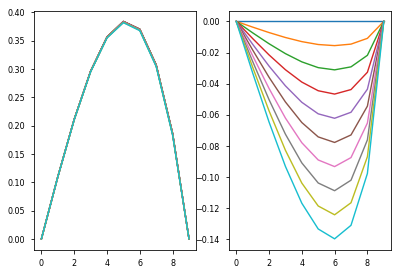

In [341]:
plt.subplot(1,2,1)
for i in range(0,NT,NT//10):
    plt.plot(data[i,0,:])
plt.subplot(1,2,2)
for i in range(0,NT,NT//10):
    plt.plot(data[i,1,:])

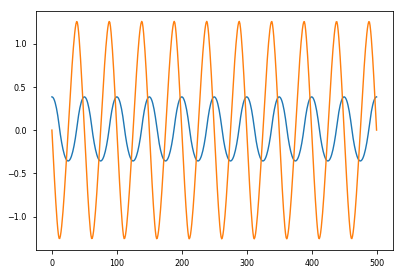

In [340]:
plt.plot(data[:,0,NX//2])
plt.plot(data[:,1,NX//2])

In [113]:
device=get_device()
set_seed()

Using the CPU


In [346]:
torch_data = data_to_torch(data, device=device)

In [211]:
import functools

In [342]:
class MultiLinear(torch.nn.Module):
    """Like Linear, but allows for higher ranks."""
    def __init__(self, in_dims, out_dims, bias=True):
        super(MultiLinear, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        in_features = functools.reduce(lambda x,y:x*y, in_dims)
        out_features = functools.reduce(lambda x,y:x*y, out_dims)
        self.net = torch.nn.Linear(in_features, out_features, bias=bias)
    def forward(self, x):
        xflat = torch.flatten(x, start_dim=-len(self.in_dims))
        hflat = self.net(xflat)
        return torch.reshape( hflat, hflat.shape[:-1]+self.out_dims )

In [343]:
model = MultiLinear((2,NX),(2,NX),bias=False).double()

In [344]:
torch_data.shape

torch.Size([25, 2, 10])

Using the CPU


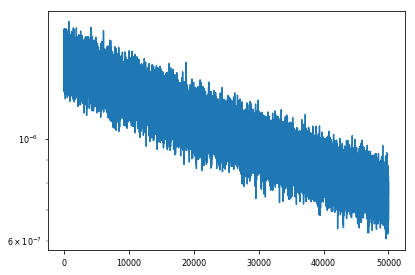

In [411]:
_,losses=learn_rnn(torch_data, model, N_iter=50000, batch_size=100,learning_rate=1.0e-3)
plt.semilogy(losses)

In [401]:
def integrate_model(step_func, u0, nsteps):
    with torch.no_grad():
        us = [u0.cpu().numpy()]
        for i in range(nsteps):
            un = step_func(u0)
            us.append(un.cpu().numpy())
            u0 = un
        U = np.array(us).reshape((-1,)+ u0.shape[1:])
    return U

In [412]:
UV = integrate_model(model, torch_data[0:1,:,:],nsteps=25)

In [413]:
UV.shape

(26, 2, 10)

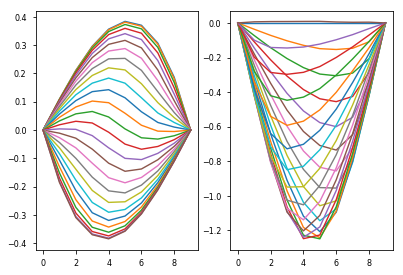

In [414]:
plt.subplot(1,2,1)
for i in range(UV.shape[0]):
    plt.plot(UV[i,0,:])
plt.subplot(1,2,2)
for i in range(UV.shape[0]):
    plt.plot(UV[i,1,:])

In [415]:
Omega = model.net.weight.detach().cpu().numpy()

In [416]:
w,V = np.linalg.eig(Omega)

In [417]:
Lambda = V.dot( np.diag(np.log(w)/dt).dot(np.linalg.inv(V)))
Lambda = np.array(Lambda,dtype=np.double)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


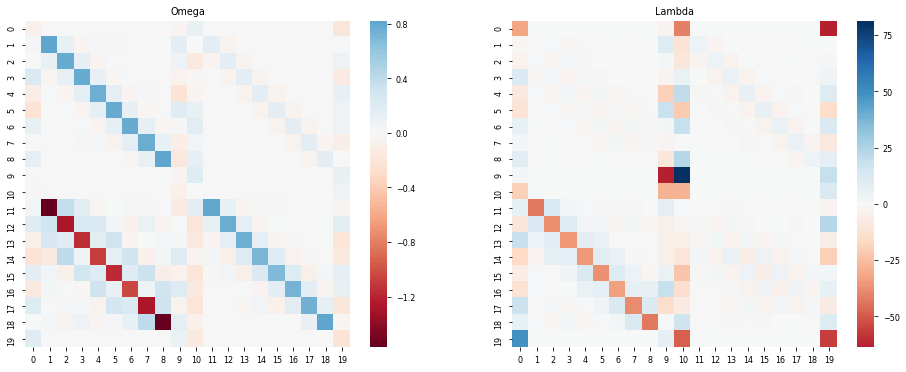

In [422]:
plt.figure(figsize=plotting.FIG_SIZE_FULL)
plt.subplot(1,2,1)
plt.title('Omega')
seaborn.heatmap(Omega, cmap='RdBu', center=0)
plt.subplot(1,2,2)
plt.title('Lambda')
seaborn.heatmap(Lambda, cmap='RdBu', center=0)